<a href="https://colab.research.google.com/github/maawoo/GEO419/blob/master/GEO419.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Some useful resources 

[Colab: Install & Use Python EE API](https://developers.google.com/earth-engine/python_install-colab)

[Colab: Github](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb) 

https://developers.google.com/earth-engine/sentinel1

[Important info about S1 dB values!](https://groups.google.com/forum/#!searchin/google-earth-engine-developers/pixel$20backscatter|sort:date/google-earth-engine-developers/QCWykrLLvZ0/mk7mwjAbAAAJ)

[Source of EE_Library functions](https://github.com/crisjosil/Sentinel_Earth_Engine/blob/master/Earth_Engine_scripts/EE_library.py)

### Initialize Earth Engine 

In [0]:
#!pip install earthengine-api

In [3]:
import ee
ee.Authenticate()
ee.Initialize()


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/tAFdFCChNNQyBhOAOntFjwLGhgndnE2-4RwahrSCgxBraok6eT9Vxjk

Successfully saved authorization token.


In [4]:
# Test: Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)


Mount Everest elevation (m): 8729


### Test 1: Backscatter timeseries for one location


In [0]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt


In [6]:
### Define location geometry
geo1 = ee.Geometry.Point([11.469602842013614, 50.95131882751624])
geo1_sq = geo1.buffer(10).bounds() #20x20m rectangle

### Load & filter the Sentinel-1 Image Collection
mode = ee.Filter.eq('instrumentMode', 'IW')
res = ee.Filter.eq('resolution', 'H') 
#pol = ee.Filter.listContains('transmitterReceiverPolarisation', 'VV') 

s1 = ee.ImageCollection('COPERNICUS/S1_GRD').filter(mode).filter(res).filterBounds(geo1)
  
s1_desc = s1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
s1_asc = s1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

count_desc = s1_desc.size().getInfo()
count_asc = s1_asc.size().getInfo()
print("Filter result: " + str(count_desc) + " descending and " + str(count_asc) + " ascending images.")


Filter result: 479 descending and 473 ascending images.


In [0]:
def get_S1_date(out):
    """ Obtains the SAR image acquisition date from the product ID
    Args:
        out (List of dictionaries): Each dictionary corresponds to the sentinel1 info of an image
    Returns:
        Dates : A list of the acquisition dates
    """
    Dates = np.zeros(len(out)).tolist()
    VH = np.zeros(len(out)).tolist()
    VV = np.zeros(len(out)).tolist()
    angle = np.zeros(len(out)).tolist()
    df = pd.DataFrame()
    for i in range(len(out)):
        a = out[i]['id']
        b = a.split(sep='_')
        #b1=b[4].split(sep='T')
        #b2=b1[0]
        b2 = b[4].replace('T', ' ')
        Dates[i] = datetime.datetime.strptime(b2, "%Y%m%d %H%M%S")
        VH[i] = out[i]['VH']
        VV[i] = out[i]['VV']
        angle[i] = out[i]['angle']
  
    df['Dates'] = Dates
    df['VH'] = VH
    df['VV'] = VV
    df['angle'] = angle
    df.set_index('Dates', inplace = True)
    return(df)

In [0]:
def Time_series_of_a_point(Img_collection,point,title):
  
    l = Img_collection.filterBounds(point).getRegion(point, 30).getInfo()
    out = [dict(zip(l[0], values)) for values in l[1:]]
    df = get_S1_date(out)
    df = df.sort_index(axis = 0)

    return(df) 

In [0]:
test = Time_series_of_a_point(s1_desc, geo1, "Test")


In [15]:
test

,VH,VV,angle
Dates,,,
2014-10-05 05:25:15,-23.067422,-12.196128,39.696533
2014-10-10 05:33:28,-21.185482,-6.468938,30.482449
2014-10-17 05:25:15,-19.348592,-9.602576,39.698639
2014-10-22 05:33:29,-15.300986,-5.624447,30.511314
2014-11-03 05:33:28,-17.833520,-7.159839,30.480713
...,...,...,...
2019-10-26 05:33:12,-23.575622,-10.134603,30.413422
2019-10-27 05:25:58,-23.082217,-15.746799,39.644314
2019-11-01 05:34:11,-21.374514,-8.730334,30.372702


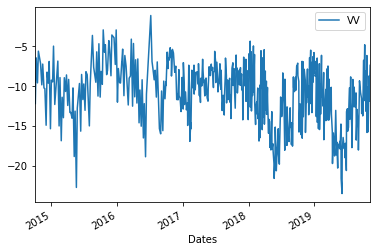

In [16]:
test.reset_index().plot(x='Dates', y='VV')
plt.show()